In [72]:
import requests
import pandas as pd
from tqdm import tqdm
import folium
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [73]:
url_inventory_txt = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-inventory.txt"
url_stations_txt = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt"
url_countries_txt = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-countries.txt"
url_states_txt = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-states.txt"
url_state_raw = "https://raw.githubusercontent.com/georgique/world-geojson/develop/states/usa/new_hampshire.json"

In [74]:
def parse_stations_txt(url):
    r = requests.get(url)
    lines = r.text.split("\n")
    data = []
    for line in lines:
        if line:
            data.append({
                "ID": line[0:11].strip(),
                "LATITUDE": float(line[12:20].strip()),
                "LONGITUDE": float(line[21:30].strip()),
                "ELEVATION": float(line[31:37].strip()),
                "STATE": line[38:40].strip(),
                "NAME": line[38:68].strip(),
            })
    return pd.DataFrame(data)

def parse_inventory_txt(url):
    r = requests.get(url)
    lines = r.text.split("\n")
    data = []
    for line in lines:
        if line:
            data.append({
                "ID": line[0:11].strip(),
                "LATITUDE": float(line[12:20].strip()),
                "LONGITUDE": float(line[21:30].strip()),
                "ELEMENT": line[31:35].strip(),
                "FIRSTYEAR": int(line[36:40].strip()),
                "LASTYEAR": int(line[41:45].strip())
            })
    return pd.DataFrame(data)

def parse_countries_txt(url):
    r = requests.get(url)
    lines = r.text.split("\n")
    data = []
    for line in lines:
        if line:
            data.append({
                "CODE": line[0:2].strip(),
                "NAME": line[3:64].strip()
            })
    return pd.DataFrame(data)

def parse_states_txt(url):
    r = requests.get(url)
    lines = r.text.split("\n")
    data = []
    for line in lines:
        if line:
            data.append({
                "CODE": line[0:2].strip(),
                "NAME": line[3:50].strip()
            })
    return pd.DataFrame(data)

def parse_data_dly(line):
    data = []
    for i in range(21, 269, 8):
        value = int(line[i:i+5])
        mflag = line[i+5]
        qflag = line[i+6]
        sflag = line[i+7]
        data.extend([value, mflag, qflag, sflag])
    return {
        "ID": line[0:11].strip(),
        "YEAR": int(line[11:15]),
        "Month": int(line[15:17]),
        "ELEMENT": line[17:21].strip(),
        "DATA": data
    }

def read_data_from_url(url):
    data = []
    response = requests.get(url)
    if response.status_code == 200:
        for line in response.text.splitlines():
            data.append(parse_data_dly(line))
    else:
        print(f"Failed to retrieve data for {url}. Status code: {response.status_code}")
    return data

def fetch_and_save_to_dataframe(station_ids):
    all_data = []
    for station_id in tqdm(station_ids, desc="Fetching Data", unit="station", ncols=100):
        url = f"https://www.ncei.noaa.gov/pub/data/ghcn/daily/all/{station_id}.dly"
        data = read_data_from_url(url)
        all_data.extend(data)
    headers = ["ID", "YEAR", "Month", "ELEMENT"]
    for i in range(1, 32):
        headers.extend([f"VALUE{i}", f"MFLAG{i}", f"QFLAG{i}", f"SFLAG{i}"])
    df_data = []
    for entry in all_data:
        row = [entry["ID"], entry["YEAR"], entry["Month"], entry["ELEMENT"]]
        row.extend(entry["DATA"])
        df_data.append(row)
    return pd.DataFrame(df_data, columns=headers)


In [75]:
inventory = parse_inventory_txt(url_inventory_txt)
stations= parse_stations_txt(url_stations_txt)
countries = parse_countries_txt(url_countries_txt)
states = parse_states_txt(url_states_txt)

In [83]:
s_state_list=stations[stations['STATE']=='NH']['ID'].tolist()
s_live_list=inventory[(inventory['ID'].isin(s_state_list)) & (inventory['LASTYEAR']>2024)]['ID'].unique().tolist()
result = inventory.loc[inventory['ID'].isin(s_live_list), ['ID', 'ELEMENT', 'FIRSTYEAR', 'LASTYEAR']]
result['YEAR_DIFF'] = result['LASTYEAR'] - result['FIRSTYEAR']
Req_station_list = pd.Series(result[(result['YEAR_DIFF'] >= 10) & (result['LASTYEAR'] > 2024)]['ID'].tolist()).unique()

In [84]:
data= fetch_and_save_to_dataframe(s_live_list)

Fetching Data: 100%|█████████████████████████████████████████| 148/148 [00:45<00:00,  3.24station/s]


In [85]:
flag_columns = [col for col in data.columns if 'FLAG' in col]
data= data.drop(columns=flag_columns)
data.replace(-9999.0, np.nan, inplace=True)
weather_variables = ['TMAX', 'TMIN', 'SNOW', 'SNWD', 'PRCP']
data=data[data['ELEMENT'].isin(weather_variables)]

In [86]:
def find_missing_months_for_station(data, station):
    station_data = data[data['ID'] == station].copy()
    station_data['YEAR_MONTH'] = station_data['YEAR'].astype(str) + '-' + station_data['Month'].astype(str).str.zfill(2)
    start_year = station_data['YEAR'].min()
    end_year = station_data['YEAR'].max()
    first_available_month = station_data[station_data['YEAR'] == start_year]['Month'].min()
    start_year_month = f"{start_year}-{str(first_available_month).zfill(2)}"
    last_available_month = station_data[station_data['YEAR'] == end_year]['Month'].max()
    available_year_month_pairs = set(station_data['YEAR_MONTH'])
    
    full_year_month_pairs = set(
        [f"{year}-{str(month).zfill(2)}" for year in range(start_year, end_year) for month in range(1, 13)]
    )
    
    missing_pairs = full_year_month_pairs - available_year_month_pairs
    missing_years = {}
    for pair in missing_pairs:
        year, month = pair.split('-')
        year = int(year)
        month = int(month)
        if year == start_year and month < first_available_month:
            continue
        if year not in missing_years:
            missing_years[year] = []
        missing_years[year].append(str(month).zfill(2))
    
    return missing_years, start_year_month, end_year, last_available_month, start_year, end_year

stations_list = data['ID'].unique()

# List to store stations without missing data
stations_without_missing_data = []

# Loop through all stations and check for missing data
for station in stations_list:
    missing_years, start_year_month, end_year, last_available_month, start_year, end_year = find_missing_months_for_station(data, station)
    
    # If missing_years is empty, that means there's no missing data for this station
    if not missing_years:
        # Calculate the duration in years
        duration = end_year - start_year + 1
        stations_without_missing_data.append((station, duration))  # Add station and duration to the list


In [87]:
stations_without_missing_data = pd.DataFrame(stations_without_missing_data, columns=['ID', 'Duration'])
stations_without_missing_data=stations_without_missing_data[stations_without_missing_data['Duration']>=15]
stations_without_missing_data=stations_without_missing_data['ID'].tolist()

In [89]:
print(f"Number of stations with at least 15 years of data for all months: {len(stations_without_missing_data)}")
stations_without_missing_data


Number of stations with at least 15 years of data for all months: 29


['US1NHBK0001',
 'US1NHBK0002',
 'US1NHBK0009',
 'US1NHCH0002',
 'US1NHCR0011',
 'US1NHGR0001',
 'US1NHHL0019',
 'US1NHHL0048',
 'US1NHHL0049',
 'US1NHMR0004',
 'US1NHMR0006',
 'US1NHMR0015',
 'US1NHMR0025',
 'US1NHRC0024',
 'US1NHSL0003',
 'US1NHSL0008',
 'USC00270913',
 'USC00272302',
 'USC00274218',
 'USC00274304',
 'USC00278614',
 'USC00279278',
 'USW00014745',
 'USW00014755',
 'USW00054728',
 'USW00054791',
 'USW00054794',
 'USW00054795',
 'USW00094700']

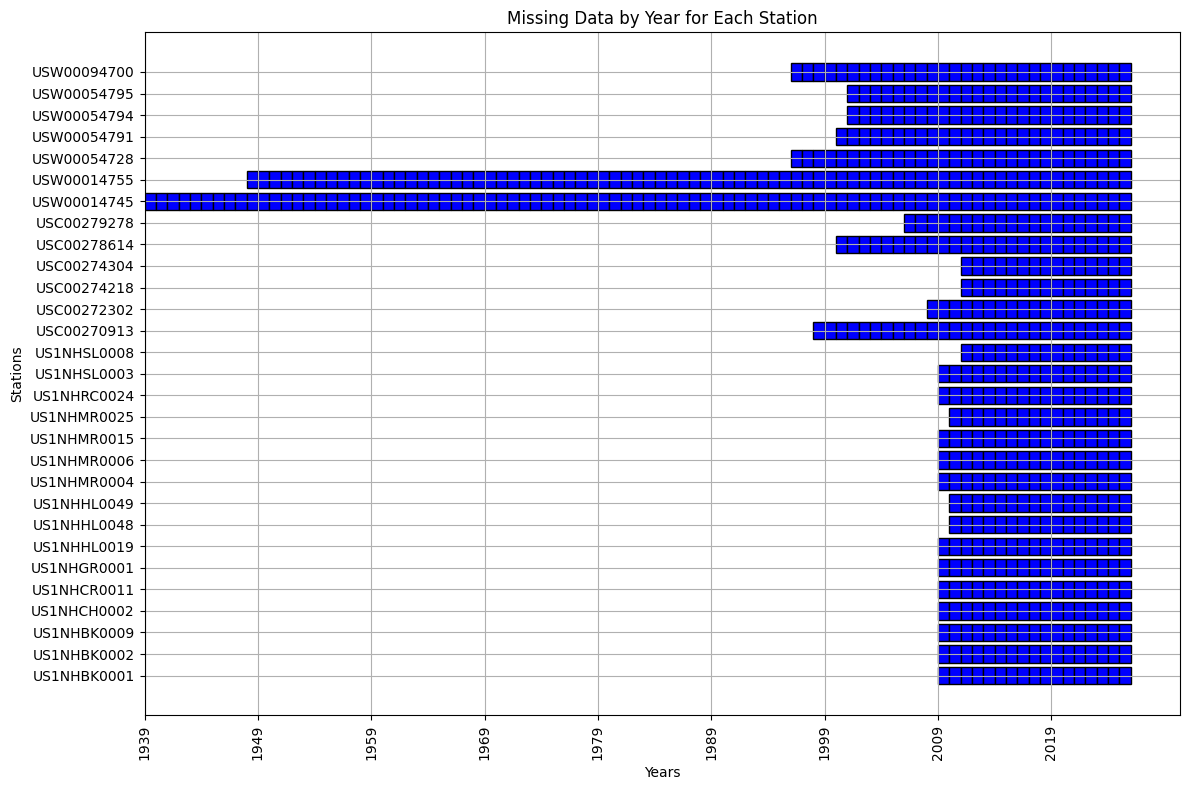

In [90]:
fig, ax = plt.subplots(figsize=(12, 8))
missing_color = 'red'
available_color = 'blue'
min_overall_year = min([data[data['ID'] == station]['YEAR'].min() for station in stations_without_missing_data])
max_overall_year = max([data[data['ID'] == station]['YEAR'].max() for station in stations_without_missing_data])

# Create the missing_by_station dictionary
missing_by_station = {}
for station in stations_without_missing_data:
    missing_years, _, _, _, _, _ = find_missing_months_for_station(data, station)
    missing_by_station[station] = missing_years

for idx, station in enumerate(stations_without_missing_data):
    min_year = data[data['ID'] == station]['YEAR'].min()
    max_year = data[data['ID'] == station]['YEAR'].max()
    if min_year == max_year:
        continue
    if min_year < max_year:
        years = np.arange(min_year, max_year + 1)
        availability_matrix = np.zeros(len(years))
        for year in missing_by_station.get(station, {}).keys():
            year_indices = np.where(years == year)
            if year_indices[0].size > 0:
                year_idx = year_indices[0][0]
                availability_matrix[year_idx] = 1 
        for i, year in enumerate(years):
            if availability_matrix[i] == 1:
                ax.barh(idx, 1, left=year, height=0.8, color=missing_color, edgecolor='black')
            else:
                ax.barh(idx, 1, left=year, height=0.8, color=available_color, edgecolor='black')
ax.set_xlabel('Years')
ax.set_ylabel('Stations')
ax.set_title('Missing Data by Year for Each Station')
x_ticks = [min_overall_year] + list(range(min_overall_year + 10, max_overall_year, 10)) 
ax.set_xticks(x_ticks)
ax.set_yticks(np.arange(len(stations_without_missing_data)))
ax.set_yticklabels(stations_without_missing_data)
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()


In [91]:
data = data[data['ID'].isin(stations_without_missing_data)]

In [92]:
data.head()

ID  YEAR  Month ELEMENT  VALUE1  VALUE2  VALUE3  VALUE4  VALUE5  \
0  US1NHBK0001  2009      6    PRCP     NaN     NaN     NaN     NaN     NaN   
1  US1NHBK0001  2009      6    SNOW     NaN     NaN     NaN     NaN     NaN   
4  US1NHBK0001  2009      7    PRCP    33.0    38.0   262.0     0.0    36.0   
5  US1NHBK0001  2009      7    SNOW     NaN     NaN     NaN     NaN     NaN   
8  US1NHBK0001  2009      8    PRCP   259.0     0.0     NaN     NaN     0.0   

   VALUE6  ...  VALUE22  VALUE23  VALUE24  VALUE25  VALUE26  VALUE27  VALUE28  \
0     NaN  ...     18.0     10.0     25.0      5.0      0.0     18.0     13.0   
1     NaN  ...      NaN      NaN      NaN      NaN      0.0      NaN      NaN   
4     0.0  ...    122.0      0.0    292.0    254.0      5.0     13.0      5.0   
5     0.0  ...      NaN      0.0      NaN      NaN      NaN      NaN      NaN   
8     0.0  ...    160.0     30.0     28.0     25.0      0.0     13.0      0.0   

   VALUE29  VALUE30  VALUE31  
0      NaN      NaN      NaN  
1      NaN      NaN      NaN  
4      0.0    566.0      0.0  
5      0.0      NaN      0.0  
8    361.0    127.0      NaN  

[5 rows x 35 columns]

In [93]:
state_stations = stations[stations['STATE']=='NH']
state_lat = state_stations['LATITUDE'].mean()
state_lon = state_stations['LONGITUDE'].mean()
state_map = folium.Map(location=[state_lat, state_lon], 
                       zoom_start=7.5,
                       min_zoom=6,
                       max_zoom=10)

stations_to_plot = stations[stations['ID'].isin(stations_without_missing_data)]
for _, row in stations_to_plot.iterrows():
    folium.Marker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        popup=row['NAME'],
        tooltip=row['NAME']
    ).add_to(state_map)
try:
    geojson_data = requests.get(url_state_raw).json() 
    folium.GeoJson(geojson_data, name="State Boundary").add_to(state_map)
except Exception as e:
    print(f"Error loading GeoJSON: {e}")
    
state_map

In [94]:
import os
def extract_and_save_variable_dataframes(df, variables, output_dir='Data/Variable_Data'):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    dataframes = {}
    for var in variables:
        var_df = df[df['ELEMENT'] == var].copy()
        dataframes[var] = var_df
        var_df.to_csv(f'{output_dir}/{var}_data.csv', index=False)
        
    return dataframes
def transform_to_daily_data(df, element):
    transformed_data = []
    for _, row in df.iterrows():
        station_id = row['ID']
        year = row['YEAR']
        month = row['Month']
        for day in range(1, 32):
            date_str = f"{year}-{month:02d}-{day:02d}"
            value_column = f'VALUE{day}'
            element_value = row.get(value_column, None)
            if pd.notna(element_value):
                transformed_data.append({
                    'DATE': date_str,
                    'ID': station_id,
                    element: element_value
                })
    transformed_df = pd.DataFrame(transformed_data)
    return transformed_df

def transform_all_variables_to_daily_data(variable_dfs, output_dir='Data/Transform_Data'):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for var, df in variable_dfs.items():
        transformed_df = transform_to_daily_data(df, var)
        transformed_df.to_csv(f'{output_dir}/{var}_data.csv', index=False)
variable_dfs = extract_and_save_variable_dataframes(data, weather_variables)
transform_all_variables_to_daily_data(variable_dfs)

In [95]:
import glob
def combine_csv_files(directory_path: str) -> pd.DataFrame:
    csv_files = glob.glob(f'{directory_path}/*_data.csv')
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found in the directory: {directory_path}")
    combined_df = pd.read_csv(csv_files[0])
    for file in csv_files[1:]:
        df = pd.read_csv(file)
        df = df.rename(columns=lambda x: x.split('_')[0] if '_' in x else x)
        combined_df = pd.merge(combined_df, df, on=['ID', 'DATE'], how='outer', suffixes=('_left', '_right'))
    return combined_df
combined_df = combine_csv_files('Data/Transform_Data')
print(combined_df.head())

         DATE           ID   PRCP  SNOW  SNWD  TMAX  TMIN
0  2009-06-19  US1NHBK0001  249.0   NaN   NaN   NaN   NaN
1  2009-06-20  US1NHBK0001   46.0   NaN   NaN   NaN   NaN
2  2009-06-21  US1NHBK0001    0.0   NaN   NaN   NaN   NaN
3  2009-06-22  US1NHBK0001   18.0   NaN   NaN   NaN   NaN
4  2009-06-23  US1NHBK0001   10.0   NaN   NaN   NaN   NaN


In [96]:
def add_season_column(df):
    df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')
    def get_season(month):
        if month in [12, 1, 2]:  # Winter: Dec, Jan, Feb
            return 'Winter'
        elif month in [3, 4, 5]:  # Spring: Mar, Apr, May
            return 'Spring'
        elif month in [6, 7, 8]:  # Summer: Jun, Jul, Aug
            return 'Summer'
        else:  # Fall: Sep, Oct, Nov
            return 'Fall'
    df['Season'] = df['DATE'].dt.month.apply(get_season)
    return df

combined_df = add_season_column(combined_df)
print(combined_df.head())

        DATE           ID   PRCP  SNOW  SNWD  TMAX  TMIN  Season
0 2009-06-19  US1NHBK0001  249.0   NaN   NaN   NaN   NaN  Summer
1 2009-06-20  US1NHBK0001   46.0   NaN   NaN   NaN   NaN  Summer
2 2009-06-21  US1NHBK0001    0.0   NaN   NaN   NaN   NaN  Summer
3 2009-06-22  US1NHBK0001   18.0   NaN   NaN   NaN   NaN  Summer
4 2009-06-23  US1NHBK0001   10.0   NaN   NaN   NaN   NaN  Summer


In [97]:
def process_columns(df, columns_to_divide):
    for col in columns_to_divide:
        df[col] = pd.to_numeric(df[col], errors='coerce')  
    for col in columns_to_divide:
        if col == 'SNOW':
            df.rename(columns={col: f"{col}"}, inplace=True)
        else:
            df[col] = df[col] / 10  
            df.rename(columns={col: f"{col}"}, inplace=True)
    
    return df
columns_to_divide = ['TMIN', 'TMAX', 'PRCP','SNOW','SNWD']
combined_df = process_columns(combined_df, columns_to_divide)
print(combined_df.head())

        DATE           ID  PRCP  SNOW  SNWD  TMAX  TMIN  Season
0 2009-06-19  US1NHBK0001  24.9   NaN   NaN   NaN   NaN  Summer
1 2009-06-20  US1NHBK0001   4.6   NaN   NaN   NaN   NaN  Summer
2 2009-06-21  US1NHBK0001   0.0   NaN   NaN   NaN   NaN  Summer
3 2009-06-22  US1NHBK0001   1.8   NaN   NaN   NaN   NaN  Summer
4 2009-06-23  US1NHBK0001   1.0   NaN   NaN   NaN   NaN  Summer


In [98]:
df_combined = pd.merge(combined_df, stations, on='ID', how='left')
df_combined = df_combined[['DATE','ID', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'NAME', 'Season', 'TMIN', 'TMAX', 'PRCP', 'SNOW', 'SNWD']]

In [99]:
df_combined.to_csv('Data/Final.csv', index=False)

In [107]:
df_combined.groupby(['ID', 'Season'])[['ELEVATION','TMIN', 'TMAX', 'SNOW', 'SNWD', 'PRCP']].agg(lambda x: x.count()).to_csv('Data/Summary.csv')


In [50]:
import pandas as pd

# Function to calculate correlation for each season
def correlation_by_season(df):
    # First, group the data by 'Season'
    seasons = df['Season'].unique()
    
    # Create an empty dictionary to store correlation matrices for each season
    correlation_matrices = {}
    
    # Iterate through each season and calculate correlation
    for season in seasons:
        season_df = df[df['Season'] == season]
        
        # Only keep the numerical columns for correlation calculation
        numerical_columns = season_df.select_dtypes(include='number')
        
        # Calculate the correlation matrix for the season's data
        correlation_matrix = numerical_columns.corr()
        
        # Store the correlation matrix in the dictionary
        correlation_matrices[season] = correlation_matrix
    
    return correlation_matrices

# Example usage:
# Assuming 'combined_df' is your DataFrame with the 'Season' column added

# Calculate correlation for each season
correlation_matrices = correlation_by_season(combined_df)

# Display correlation matrices for each season
for season, corr_matrix in correlation_matrices.items():
    print(f"Correlation Matrix for {season}:")
    print(corr_matrix)
    print("\n")


Correlation Matrix for Summer:
          PRCP      SNOW      SNWD      TMAX      TMIN
PRCP  1.000000  0.063818  0.019661 -0.206810  0.025472
SNOW  0.063818  1.000000  0.313300 -0.116009 -0.122036
SNWD  0.019661  0.313300  1.000000 -0.099309 -0.100376
TMAX -0.206810 -0.116009 -0.099309  1.000000  0.728530
TMIN  0.025472 -0.122036 -0.100376  0.728530  1.000000


Correlation Matrix for Fall:
          PRCP      SNOW      SNWD      TMAX      TMIN
PRCP  1.000000  0.325941  0.083382 -0.081454  0.060170
SNOW  0.325941  1.000000  0.400867 -0.319484 -0.308777
SNWD  0.083382  0.400867  1.000000 -0.422862 -0.402762
TMAX -0.081454 -0.319484 -0.422862  1.000000  0.819907
TMIN  0.060170 -0.308777 -0.402762  0.819907  1.000000


Correlation Matrix for Winter:
          PRCP      SNOW      SNWD      TMAX      TMIN
PRCP  1.000000  0.685912  0.074024  0.073889  0.125700
SNOW  0.685912  1.000000  0.188462 -0.150776 -0.085335
SNWD  0.074024  0.188462  1.000000 -0.275384 -0.300916
TMAX  0.073889 -0.150776 

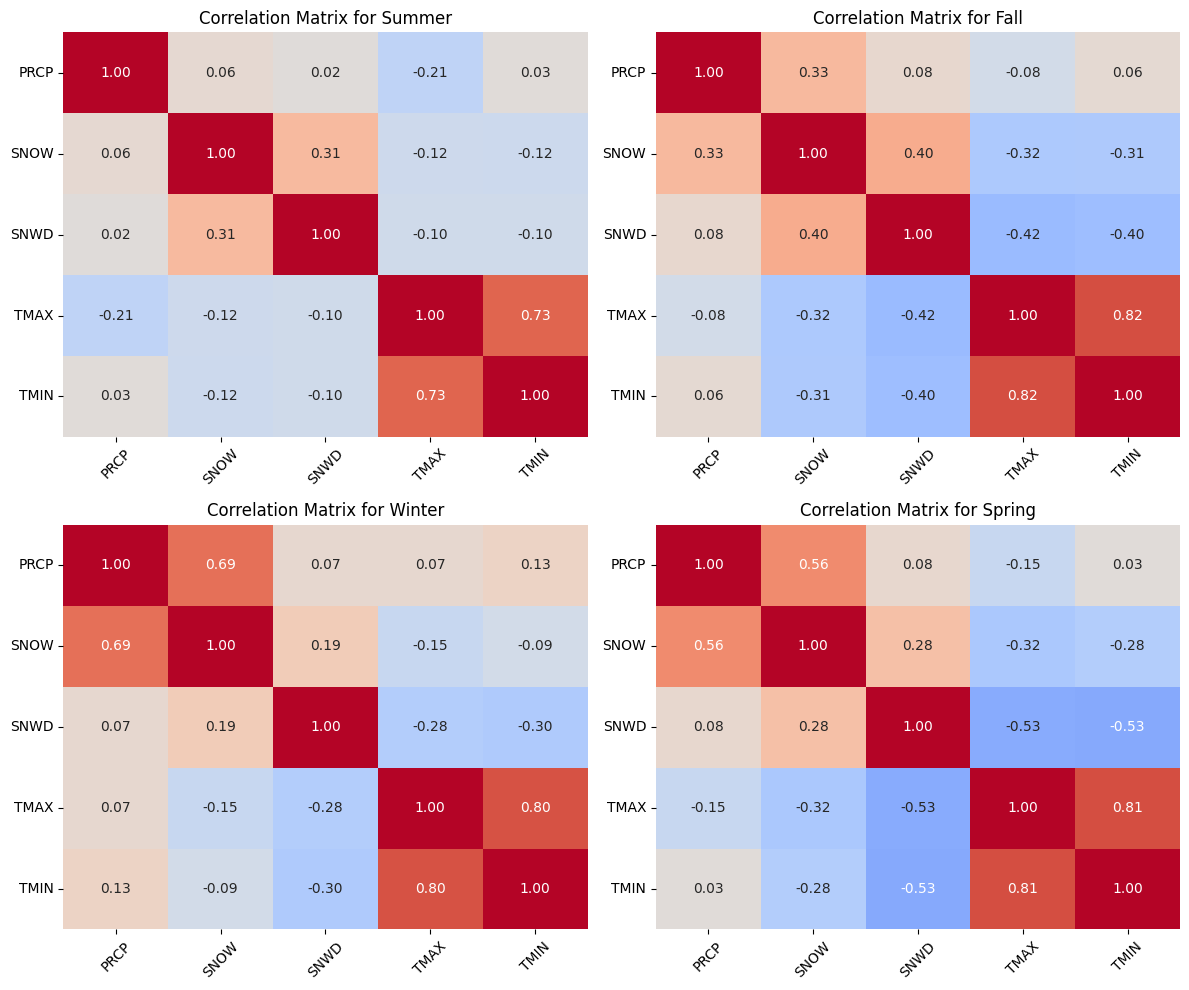

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot correlation for all seasons in a single figure with 4 quadrants
def plot_seasonal_correlations_in_quadrants(correlation_matrices):
    # Create a 2x2 subplot grid
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Adjust the size of the figure
    
    # Iterate over the seasons and their corresponding subplot axes
    seasons = ['Winter', 'Spring', 'Summer', 'Fall']
    for i, (season, corr_matrix) in enumerate(correlation_matrices.items()):
        row = i // 2  # Determine row (0 or 1)
        col = i % 2   # Determine column (0 or 1)
        
        # Plot the heatmap for each season in the corresponding subplot
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, 
                    ax=axes[row, col], cbar=False, fmt='.2f')
        
        # Set the title and axis labels for each subplot
        axes[row, col].set_title(f'Correlation Matrix for {season}')
        axes[row, col].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability
        axes[row, col].tick_params(axis='y', rotation=0)   # Keep y-axis labels upright
    
    # Adjust the layout to prevent overlap and show the figure
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'correlation_matrices' is a dictionary with the correlation matrices for each season
plot_seasonal_correlations_in_quadrants(correlation_matrices)


In [87]:
import pandas as pd

# Group by 'ID' (Station) and 'Season' and then apply describe
season_station_desc = df.groupby(['ID','Season']).describe().round(2)

# List of attributes (columns) you want to analyze
attributes = ['TMIN(°C)', 'TMAX(°C)', 'PRCP(mm)', 'SNOW(mm)', 'SNWD(cm)']

# Loop over each attribute and display its descriptive statistics
for attribute in attributes:
    print(f"Descriptive Statistics for {attribute}:")
    print(season_station_desc[attribute])
    print("\n" + "="*50 + "\n")  # Separator for better readability


Descriptive Statistics for TMIN(°C):
                      count   mean   std   min   25%   50%   75%    max
ID          Season                                                     
USC00272174 Fall    11680.0   3.79  6.74 -25.0  -1.1   3.3   8.9   23.9
            Spring  11722.0   0.78  6.47 -27.8  -3.3   0.6   5.0   30.0
            Summer  11801.0  12.98  4.31  -2.2  10.0  13.3  16.1   29.4
            Winter  11543.0  -9.07  6.74 -37.2 -13.3  -8.3  -3.9   15.0
USC00272999 Fall     9169.0   0.26  6.87 -25.0  -3.9   0.0   5.0   20.0
            Spring   9266.0  -4.62  8.96 -37.8  -9.4  -2.8   1.1   18.3
            Summer   9243.0   9.77  4.35  -3.9   6.7  10.0  12.8   22.2
            Winter   9140.0 -16.83  9.11 -71.1 -23.3 -16.7  -9.4    8.3
USC00273850 Fall    11889.0   3.39  6.86 -24.4  -1.7   3.3   8.3   22.2
            Spring  11941.0   0.11  7.30 -35.0  -3.9   0.0   5.0   24.4
            Summer  11991.0  13.01  4.19 -10.6  10.0  13.3  16.1   25.0
            Winter  11782.0

In [70]:
df_combined_with_missing_dates_and_seasons[df_combined_with_missing_dates_and_seasons["ID"]=='USC00275868']

DATE           ID  LATITUDE  LONGITUDE  ELEVATION        NAME  \
38715   1930-01-01  USC00275868   43.3772   -72.1811      234.7  NH NEWPORT   
38721   1930-01-02  USC00275868   43.3772   -72.1811      234.7  NH NEWPORT   
38726   1930-01-03  USC00275868   43.3772   -72.1811      234.7  NH NEWPORT   
38735   1930-01-04  USC00275868   43.3772   -72.1811      234.7  NH NEWPORT   
38740   1930-01-05  USC00275868   43.3772   -72.1811      234.7  NH NEWPORT   
...            ...          ...       ...        ...        ...         ...   
278111  2025-02-16  USC00275868   43.3772   -72.1811      234.7  NH NEWPORT   
278117  2025-02-17  USC00275868   43.3772   -72.1811      234.7  NH NEWPORT   
278121  2025-02-18  USC00275868   43.3772   -72.1811      234.7  NH NEWPORT   
278131  2025-02-19  USC00275868   43.3772   -72.1811      234.7  NH NEWPORT   
278137  2025-02-20  USC00275868   43.3772   -72.1811      234.7  NH NEWPORT   

        Season  TMIN  TMAX  PRCP  SNOW  SNWD  
38715   Winter   NaN   NaN   2.5   0.0  10.2  
38721   Winter   NaN   NaN   0.0   0.0  10.2  
38726   Winter   NaN   NaN   4.1   0.0   7.6  
38735   Winter   NaN   NaN   0.0   0.0   7.6  
38740   Winter   NaN   NaN   0.0   0.0   7.6  
...        ...   ...   ...   ...   ...   ...  
278111  Winter -18.3  -4.4   7.6  76.0  35.6  
278117  Winter  -9.4  -3.9  17.3  76.0  35.6  
278121  Winter   NaN   NaN   0.0   0.0  35.6  
278131  Winter   NaN   NaN   NaN   NaN   NaN  
278137  Winter -20.6  -4.4   0.0   0.0  33.0  

[34750 rows x 12 columns]

In [69]:
missing_data = df_combined_with_missing_dates_and_seasons.groupby(['ID', 'Season']).apply(lambda x: x.isnull().sum())
missing_data

C:\Users\lokes\AppData\Local\Temp\ipykernel_11368\3787410487.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_data = df_combined_with_missing_dates_and_seasons.groupby(['ID', 'Season']).apply(lambda x: x.isnull().sum())


DATE  ID  LATITUDE  LONGITUDE  ELEVATION  NAME  Season  \
ID          Season                                                           
USC00272174 Fall       0   0         0          0          0     0       0   
            Spring     0   0         0          0          0     0       0   
            Summer     0   0         0          0          0     0       0   
            Winter     0   0         0          0          0     0       0   
USC00272999 Fall       0   0         0          0          0     0       0   
            Spring     0   0         0          0          0     0       0   
            Summer     0   0         0          0          0     0       0   
            Winter     0   0         0          0          0     0       0   
USC00273850 Fall       0   0         0          0          0     0       0   
            Spring     0   0         0          0          0     0       0   
            Summer     0   0         0          0          0     0       0   
            Winter     0   0         0          0          0     0       0   
USC00274399 Fall       0   0         0          0          0     0       0   
            Spring     0   0         0          0          0     0       0   
            Summer     0   0         0          0          0     0       0   
            Winter     0   0         0          0          0     0       0   
USC00275868 Fall       0   0         0          0          0     0       0   
            Spring     0   0         0          0          0     0       0   
            Summer     0   0         0          0          0     0       0   
            Winter     0   0         0          0          0     0       0   
USC00276818 Fall       0   0         0          0          0     0       0   
            Spring     0   0         0          0          0     0       0   
            Summer     0   0         0          0          0     0       0   
            Winter     0   0         0          0          0     0       0   
USW00014745 Fall       0   0         0          0          0     0       0   
            Spring     0   0         0          0          0     0       0   
            Summer     0   0         0          0          0     0       0   
            Winter     0   0         0          0          0     0       0   

                    TMIN  TMAX  PRCP  SNOW  SNWD  
ID          Season                                
USC00272174 Fall     150   148  1418  4067  4793  
            Spring   269   259  1723  3756  4888  
            Summer   221   199  1428  4910  4934  
            Winter   248   234  1691  2337  4458  
USC00272999 Fall     113   114   184   527  1759  
            Spring   118   122   143   310  1262  
            Summer   141   139   187  1181  1914  
            Winter   122   119   231   508   930  
USC00273850 Fall     123   160   674  3458  5031  
            Spring   111   135   820  2890  4873  
            Summer   153   170   877  5036  5047  
            Winter   126   114   732  1917  4110  
USC00274399 Fall     188   192  1246  3733  5287  
            Spring   160   161  1142  3214  5080  
            Summer   132   134  1222  5274  5278  
            Winter   100   101  1116  2025  4564  
USC00275868 Fall    5520  5536    20   230   277  
            Spring  5578  5569   101   404   522  
            Summer  5595  5595    10   252   259  
            Winter  5591  5591   185   586   877  
USC00276818 Fall     100    98   514   691  1594  
            Spring   104    93   365   534   784  
            Summer   100    98   415  1067  1719  
            Winter   126   131   416   417   368  
USW00014745 Fall       0     0     0    89   752  
            Spring     0     0     0   153   549  
            Summer     2     2     0    92   921  
            Winter     0     0    32   160   270

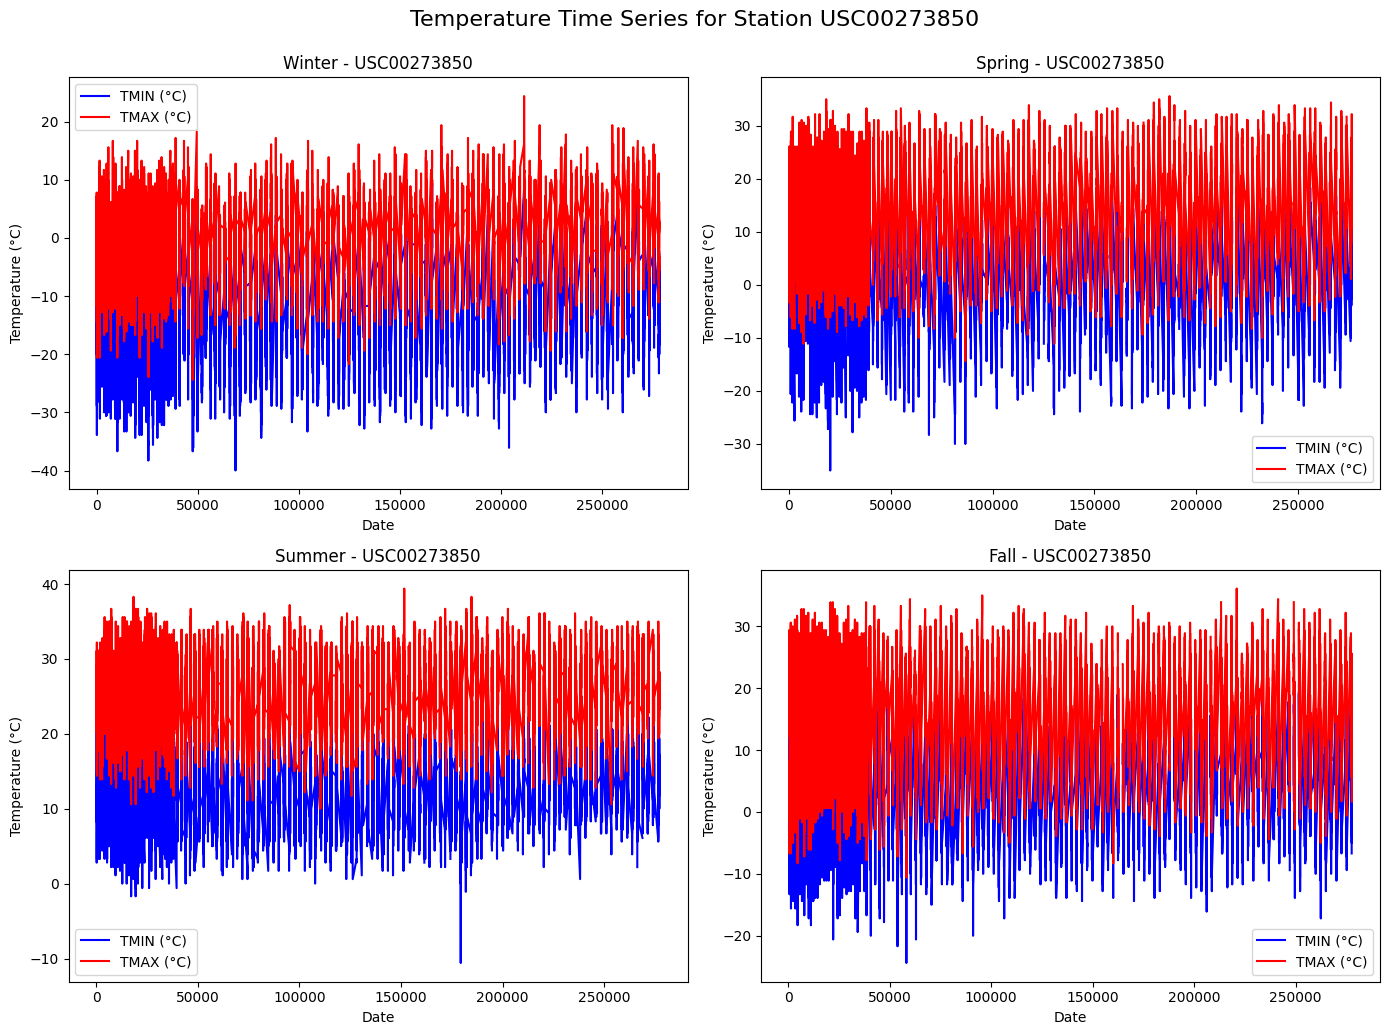

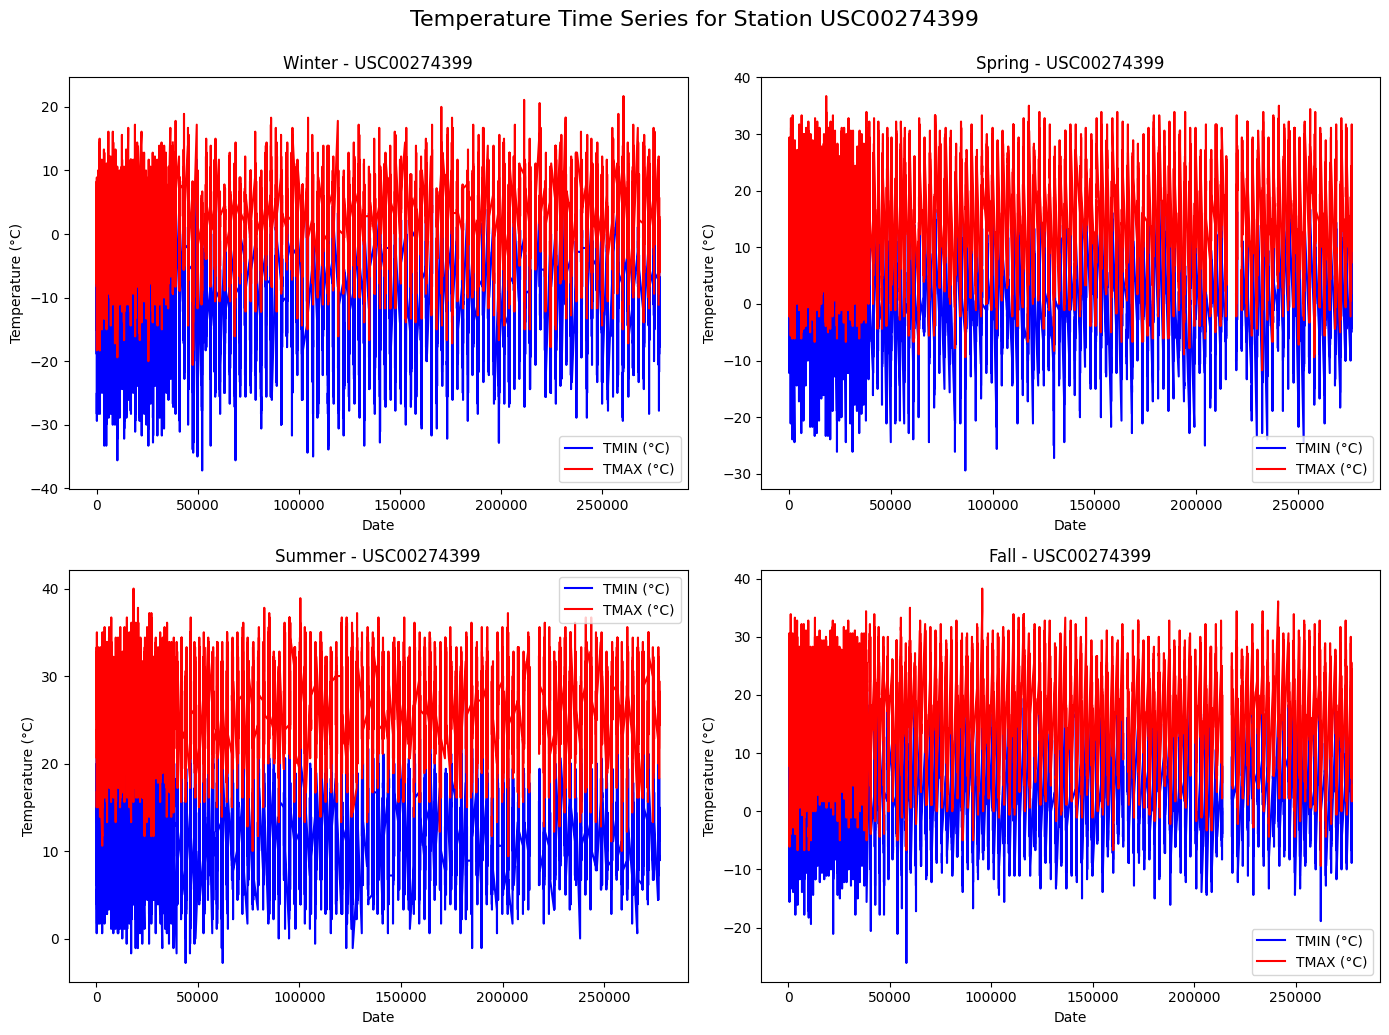

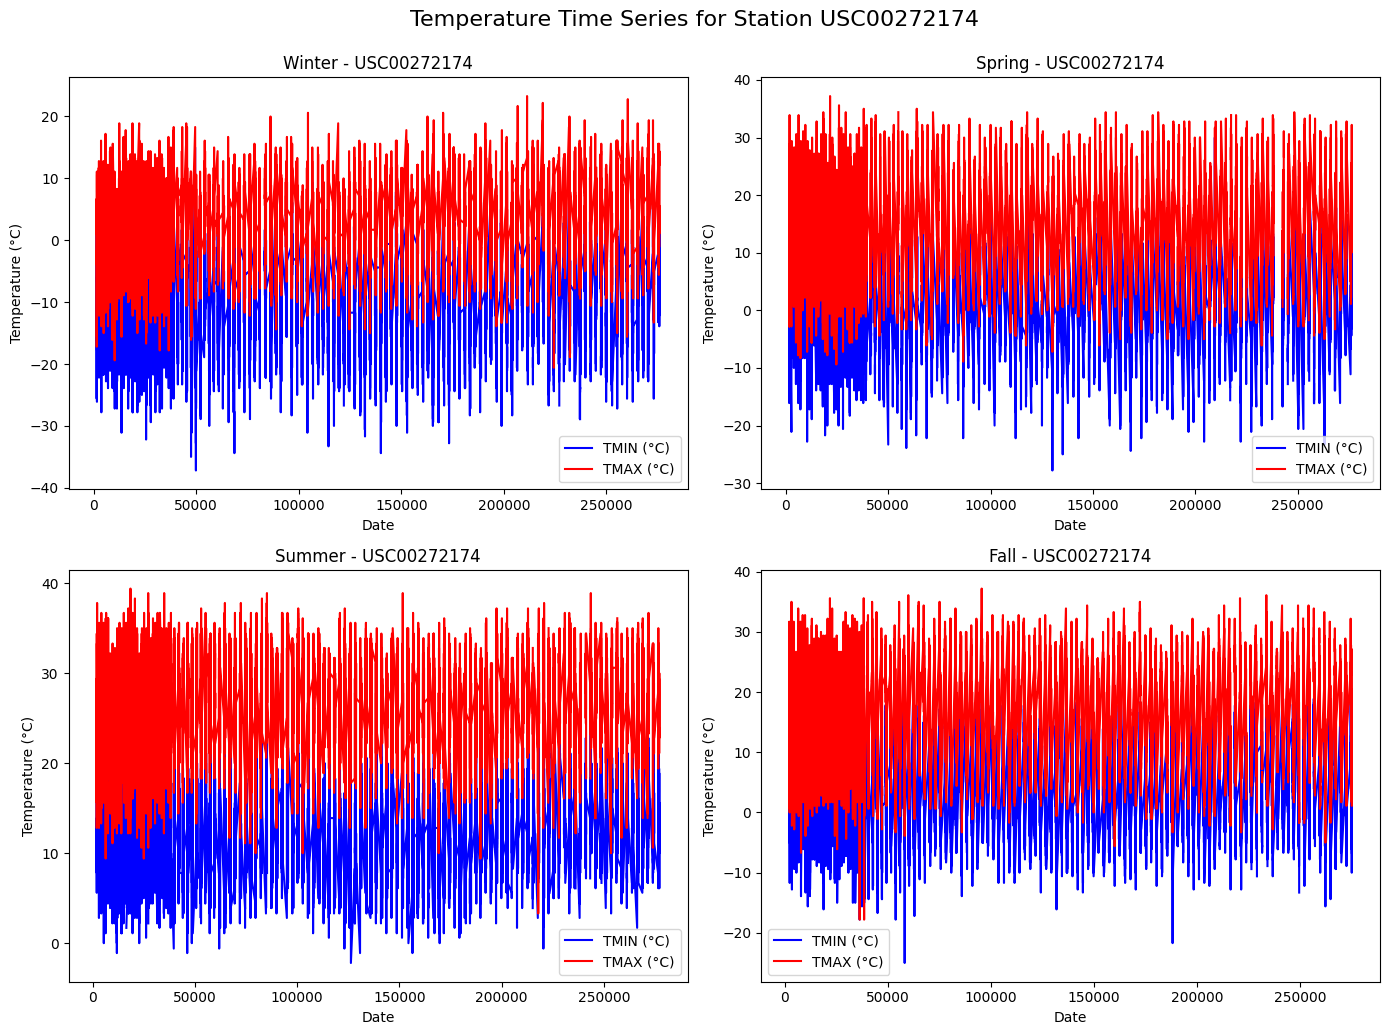

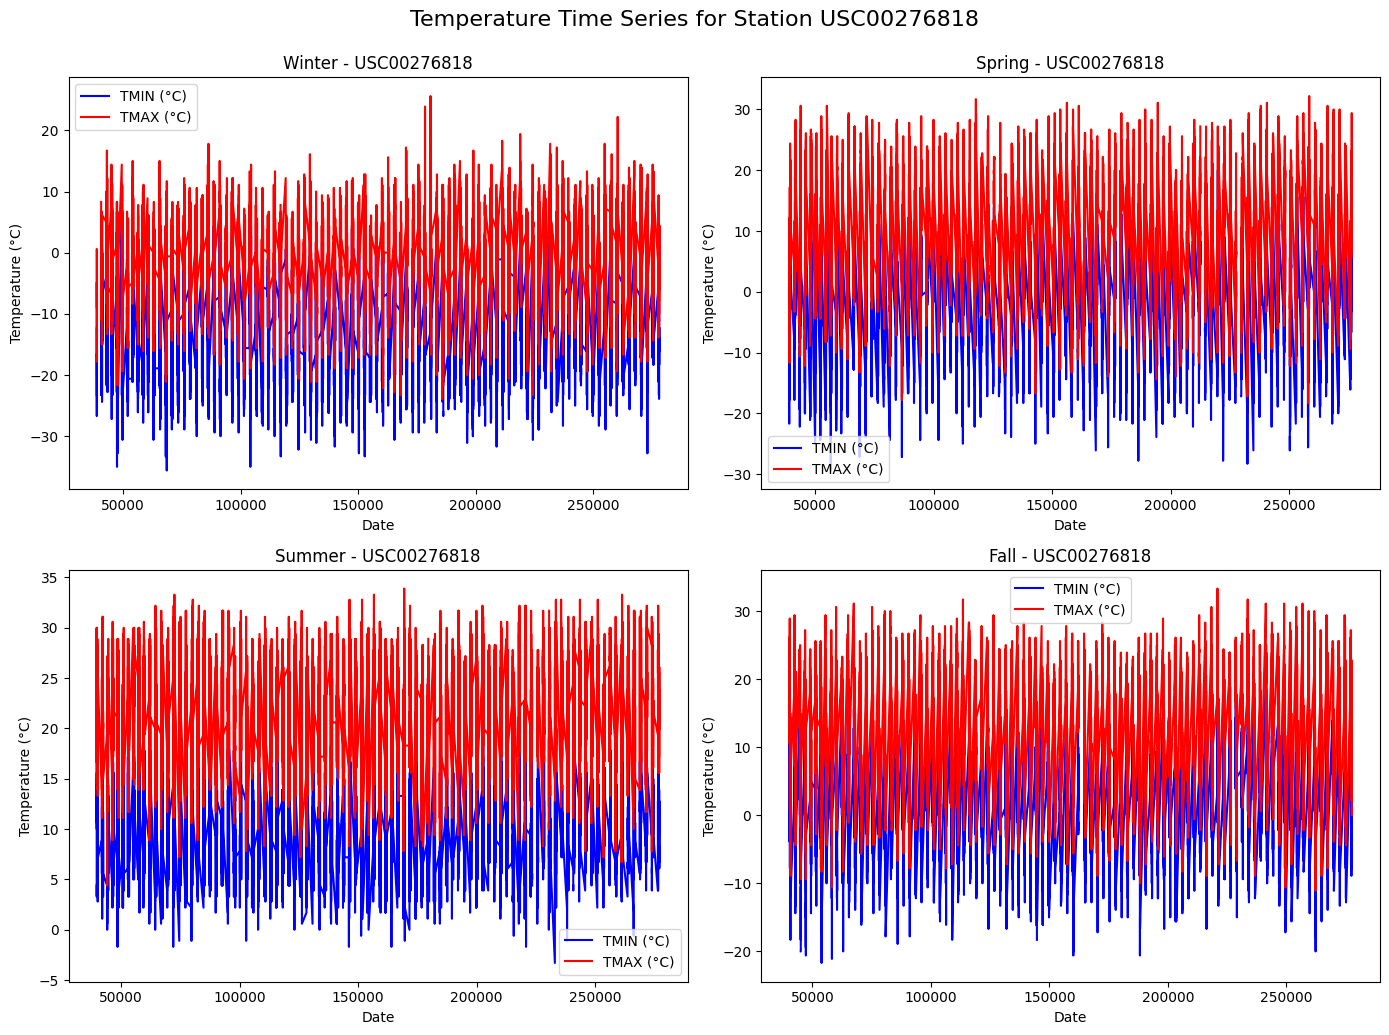

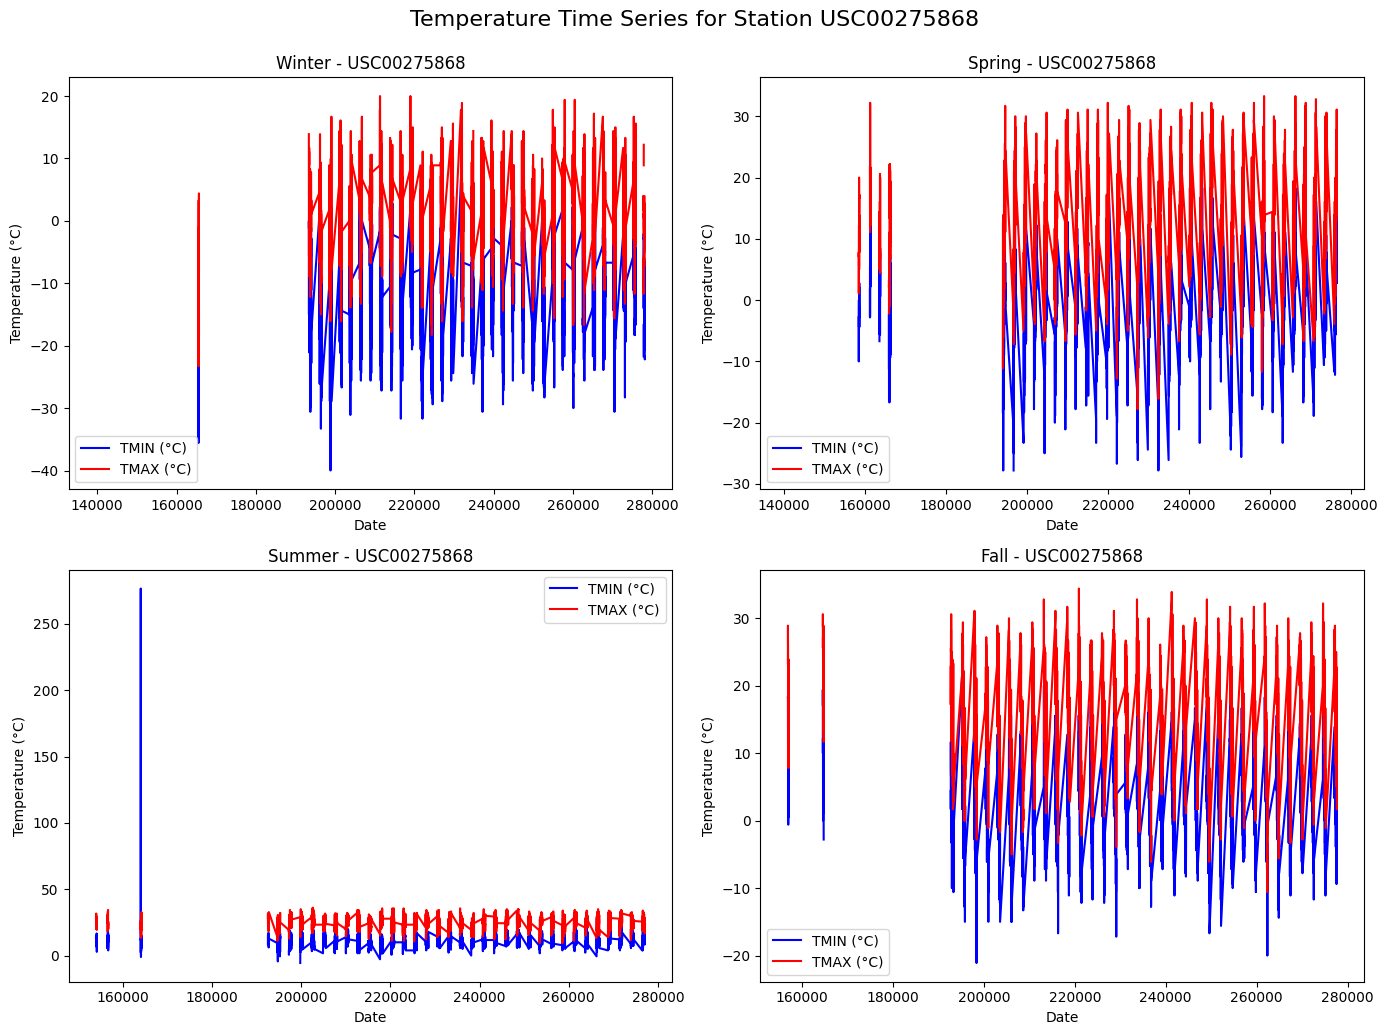

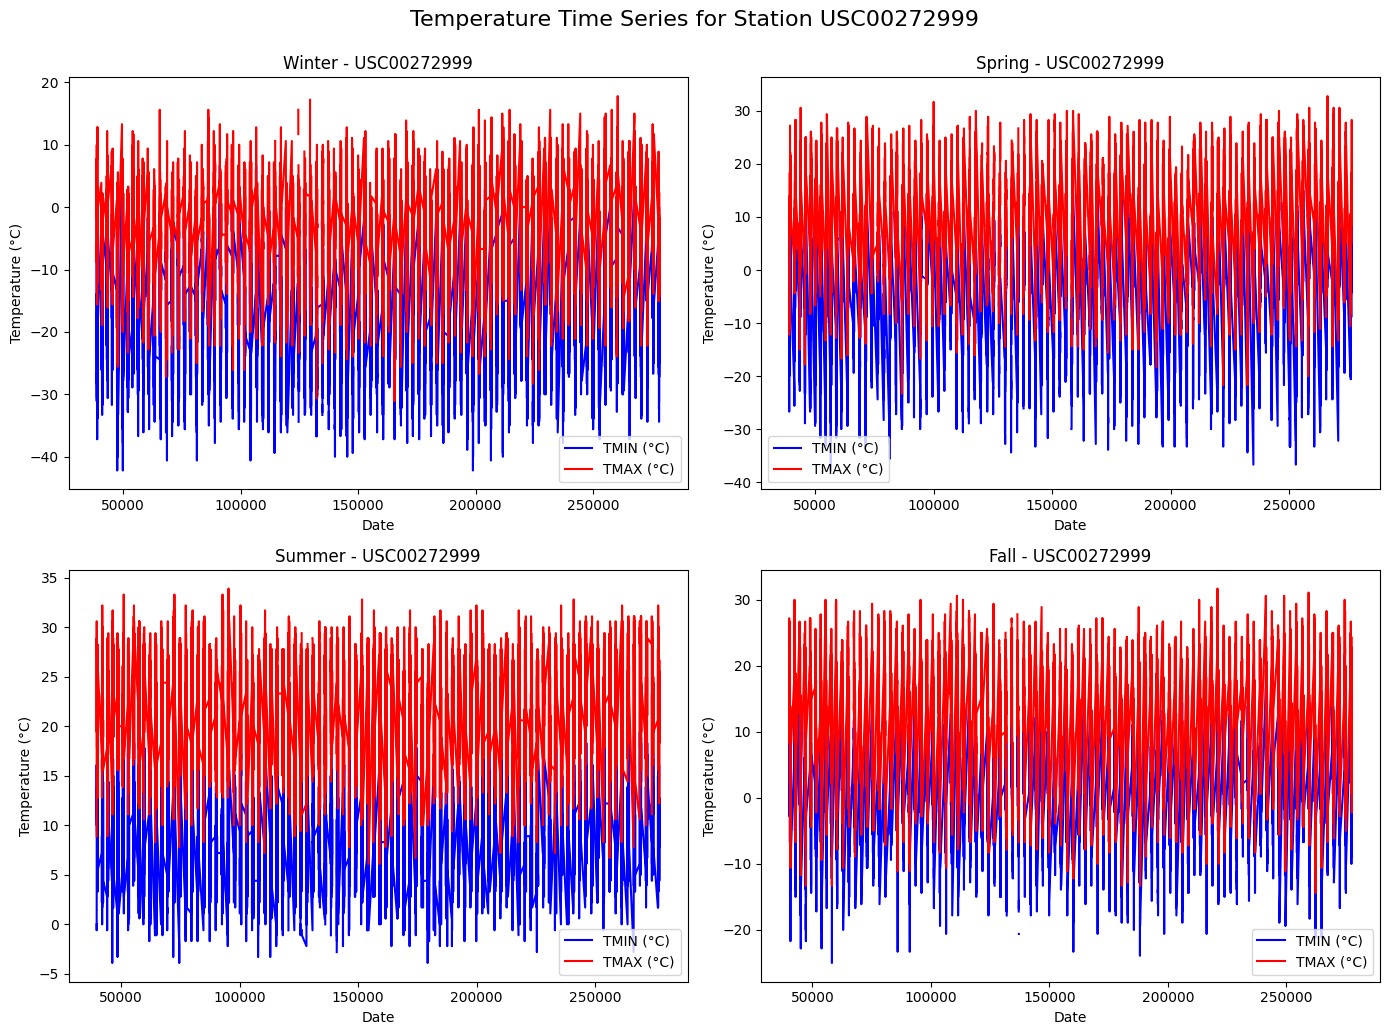

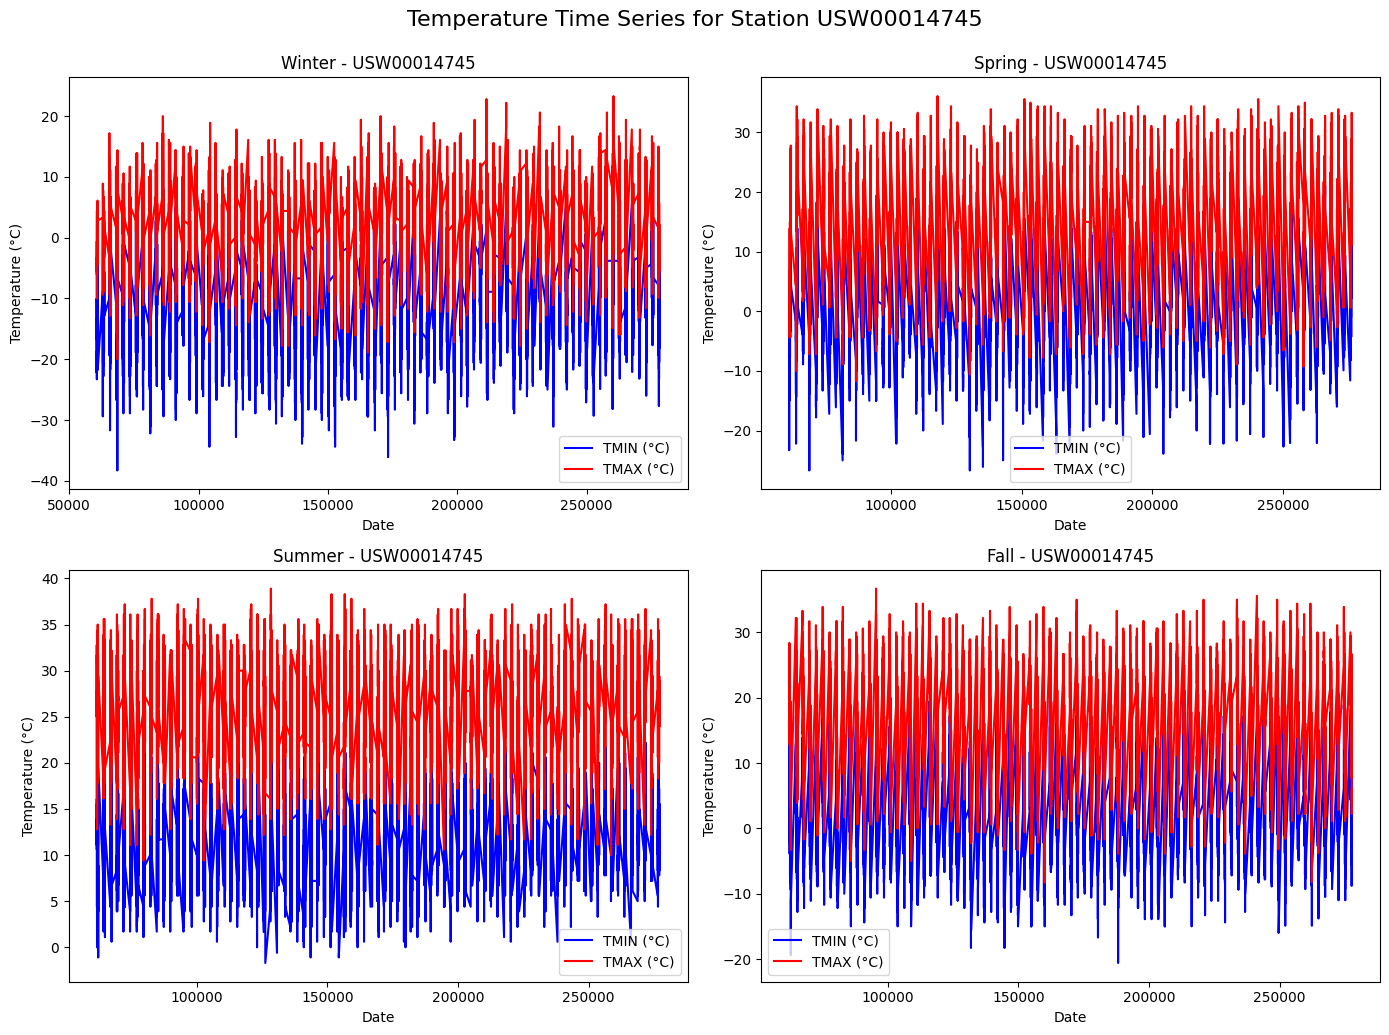

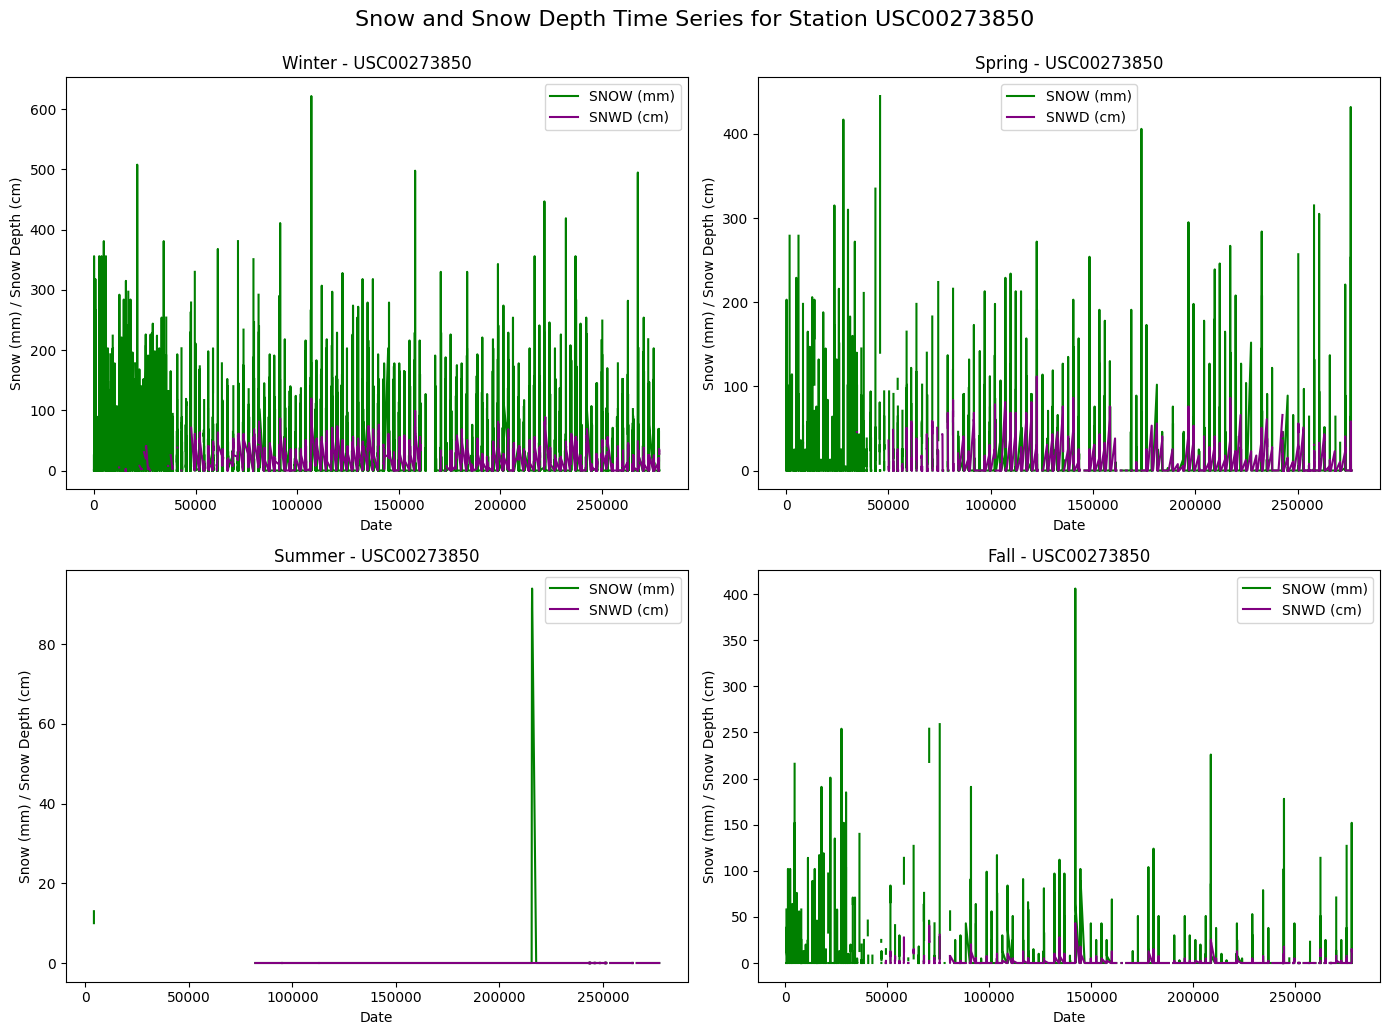

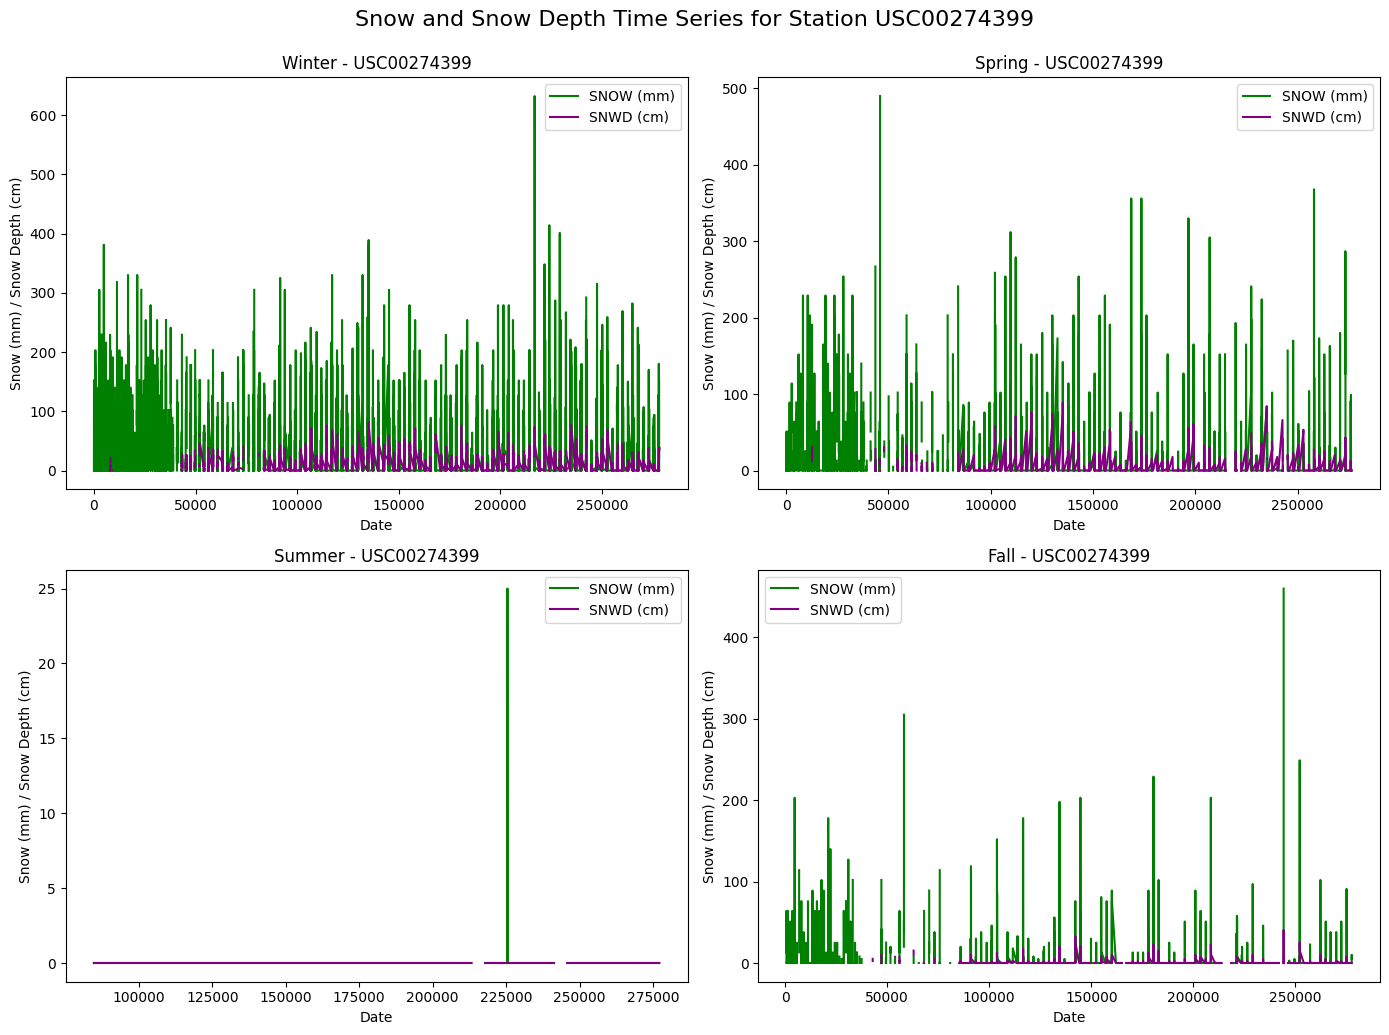

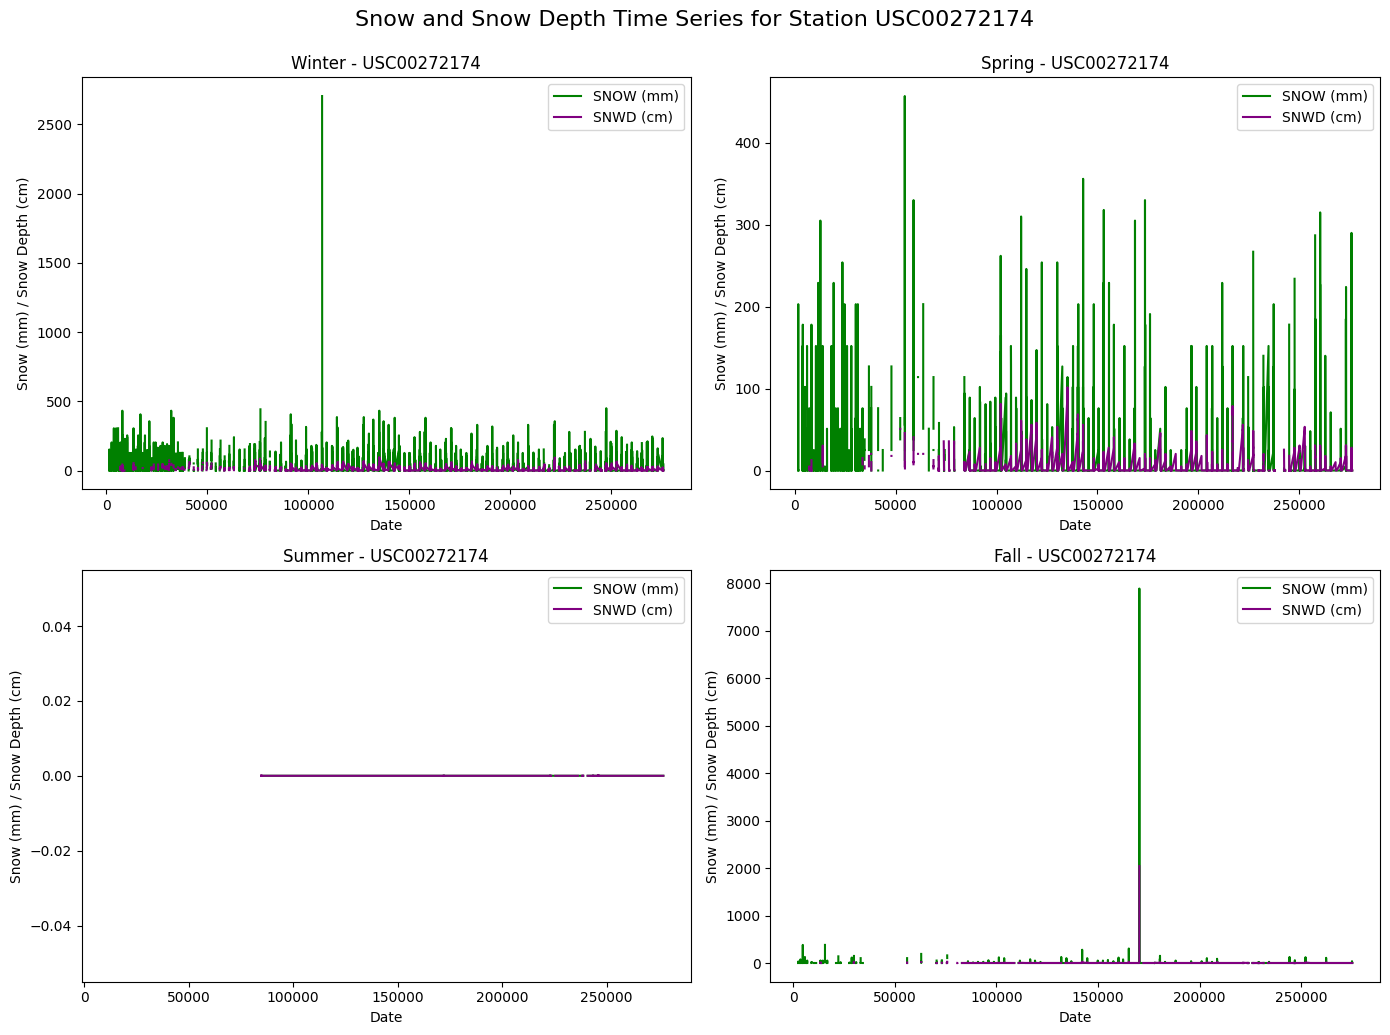

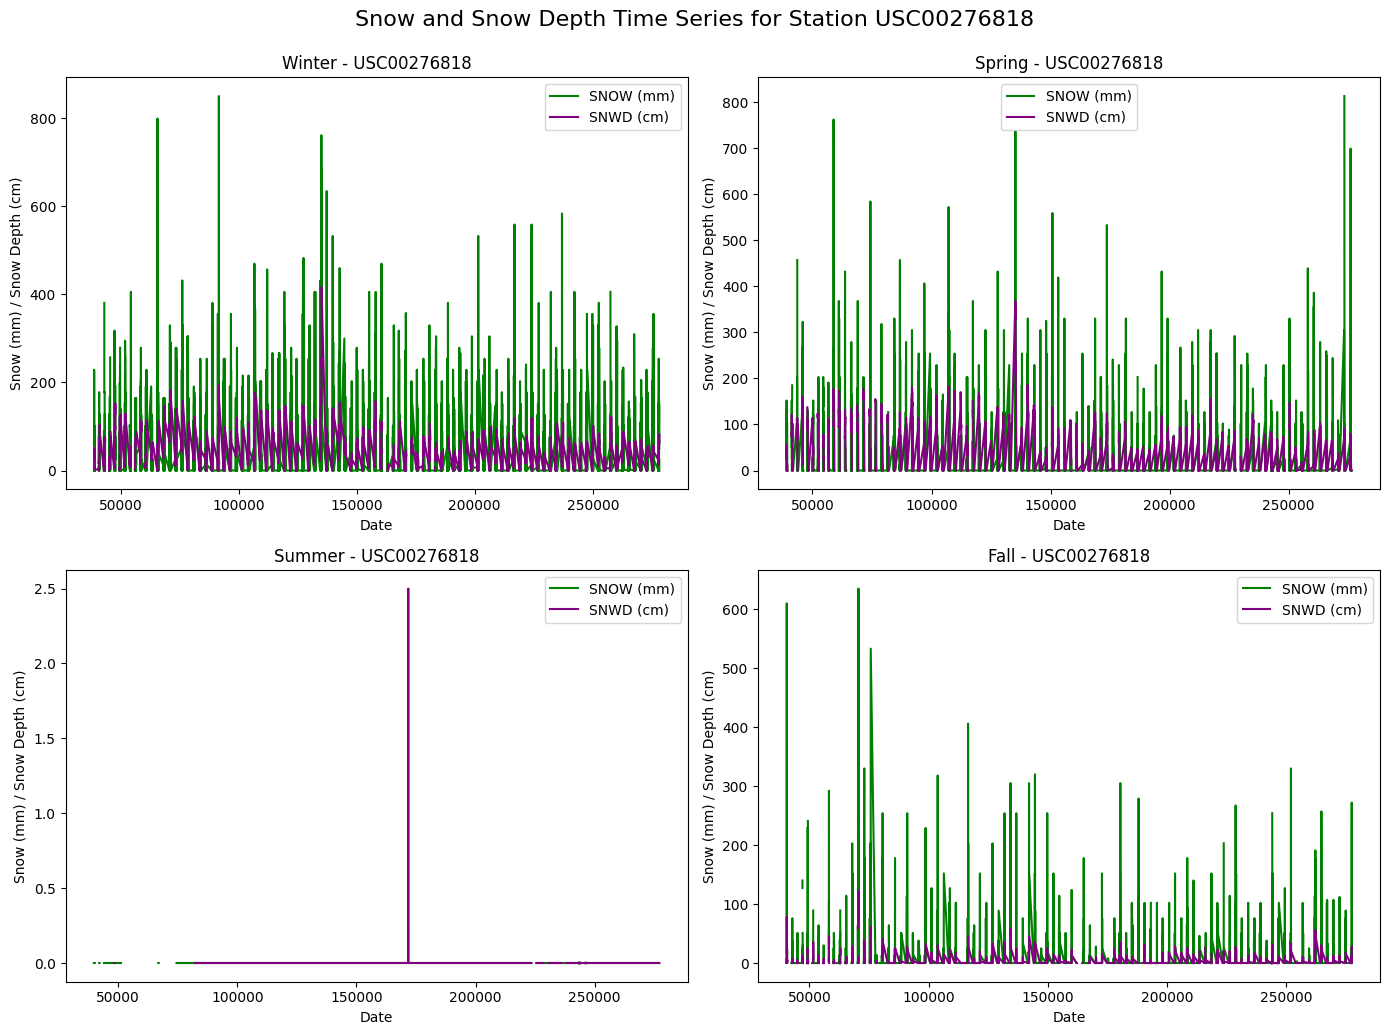

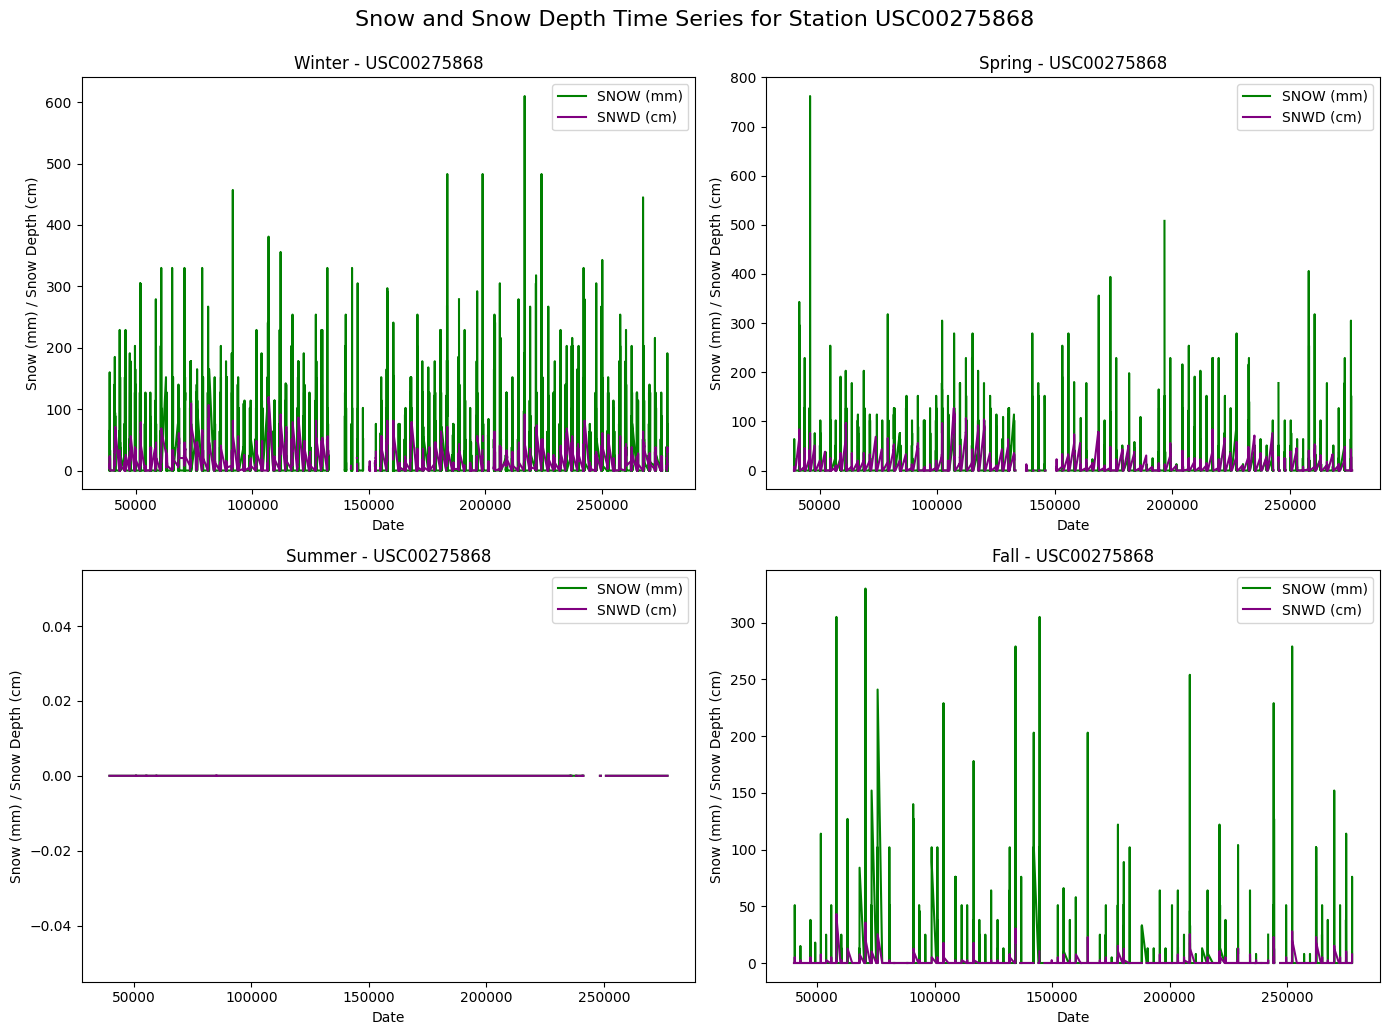

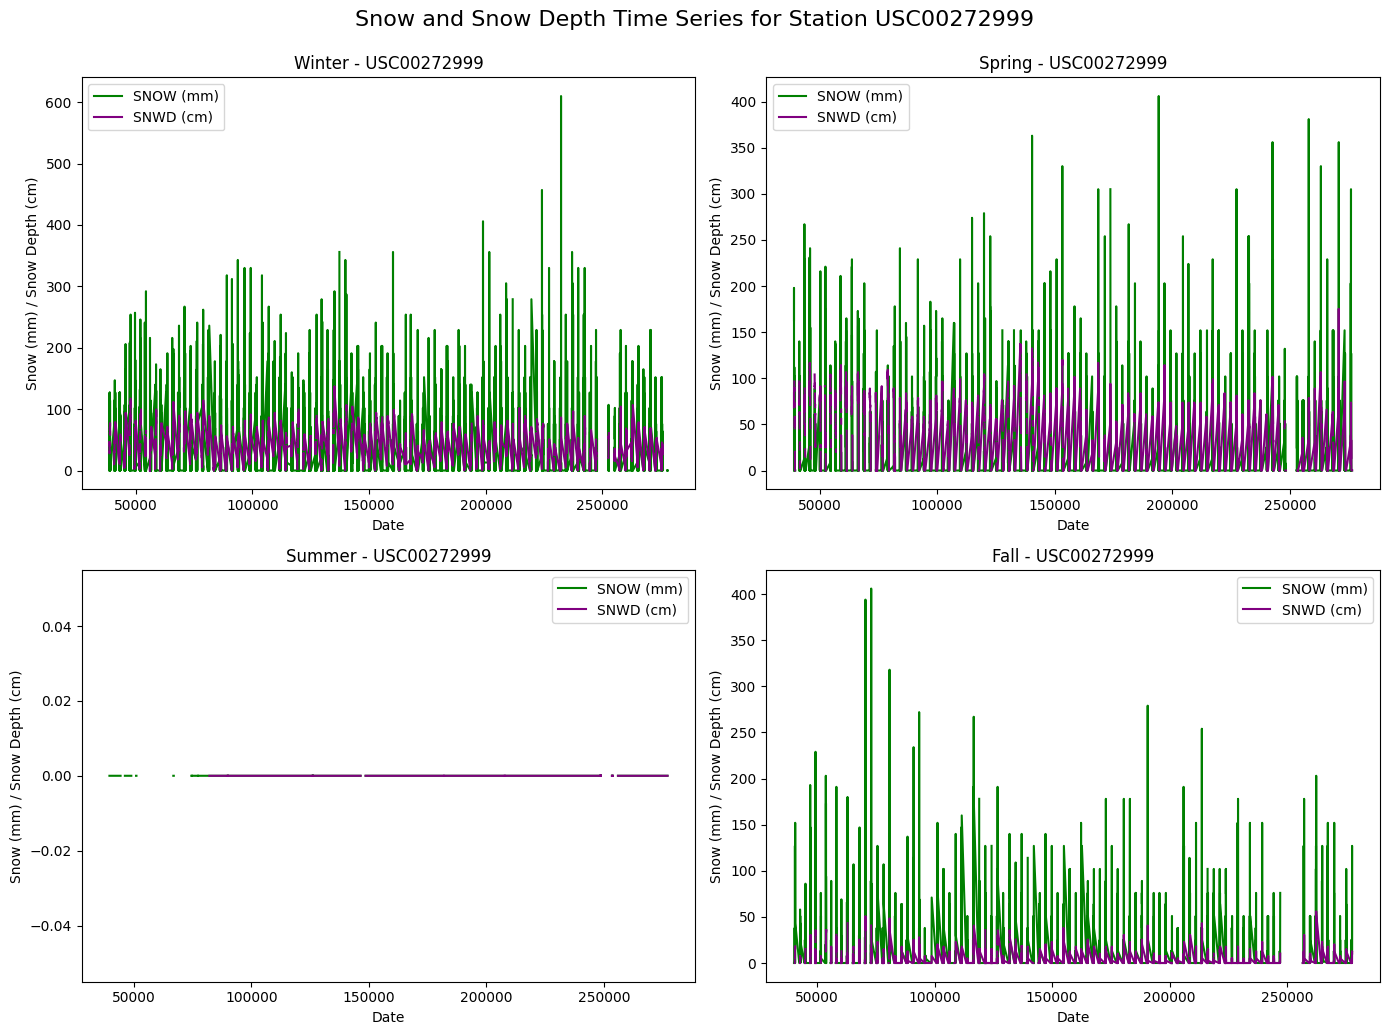

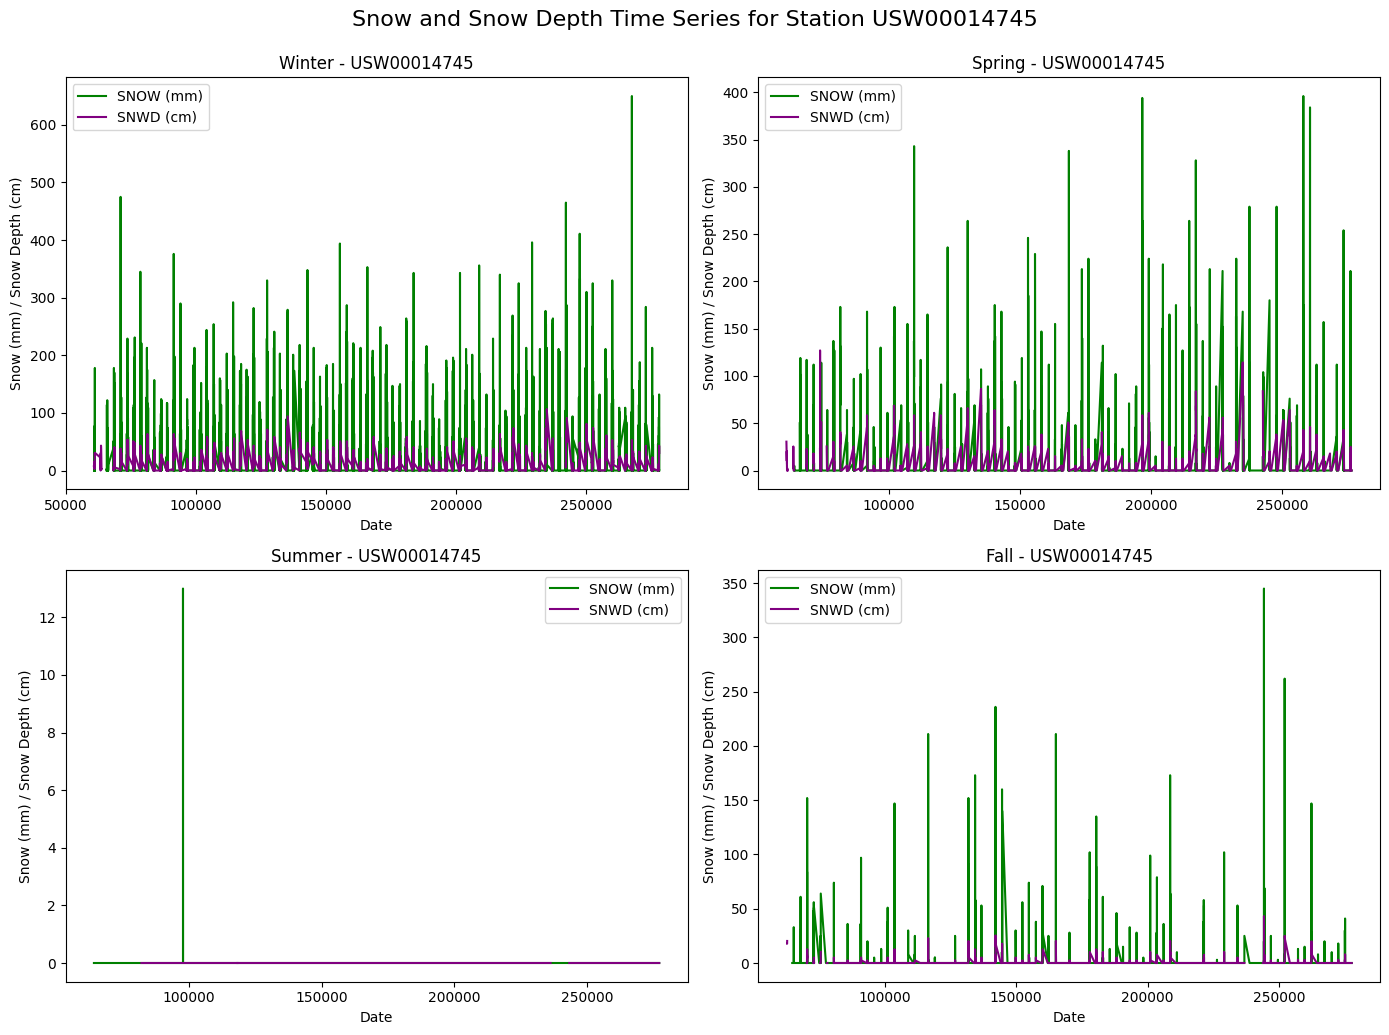

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and it has already been loaded
# Make sure that the 'DATE' column is a datetime object and set as the index

# Loop through each station (ID)
stations = df_combined_with_missing_dates_and_seasons['ID'].unique()
for station in stations:
    station_data = df_combined_with_missing_dates_and_seasons[df_combined_with_missing_dates_and_seasons['ID'] == station]
    
    # Create a figure for each station
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 2x2 grid of subplots (4 seasons)
    axes = axes.flatten()  # Flatten to make it easier to access each subplot

    # Loop through each season and plot the data
    seasons = ['Winter', 'Spring', 'Summer', 'Fall']
    for i, season in enumerate(seasons):
        season_data = station_data[station_data['Season'] == season]
        
        # Plot the time series for TMIN and TMAX for the current season
        axes[i].plot(season_data.index, season_data['TMIN'], label='TMIN (°C)', color='blue')
        axes[i].plot(season_data.index, season_data['TMAX'], label='TMAX (°C)', color='red')
        
        # Set title and labels for each subplot
        axes[i].set_title(f"{season} - {station}")
        axes[i].set_xlabel("Date")
        axes[i].set_ylabel("Temperature (°C)")
        axes[i].legend()

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.suptitle(f"Temperature Time Series for Station {station}", fontsize=16, y=1.03)
    plt.show()

for station in stations:
    station_data = df_combined_with_missing_dates_and_seasons[df_combined_with_missing_dates_and_seasons['ID'] == station]
    
    # Create a figure for each station with 2x2 subplots (one for each season)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 2x2 grid for the four seasons
    axes = axes.flatten()  # Flatten to make it easier to access each subplot
    
    # Loop through each season and plot the data for SNOW and SNWD
    seasons = ['Winter', 'Spring', 'Summer', 'Fall']
    for i, season in enumerate(seasons):
        season_data = station_data[station_data['Season'] == season]
        
        # Plot the time series for SNOW and SNWD for the current season
        axes[i].plot(season_data.index, season_data['SNOW'], label='SNOW (mm)', color='green')
        axes[i].plot(season_data.index, season_data['SNWD'], label='SNWD (cm)', color='purple')
        
        # Set title and labels for each subplot
        axes[i].set_title(f"{season} - {station}")
        axes[i].set_xlabel("Date")
        axes[i].set_ylabel("Snow (mm) / Snow Depth (cm)")
        axes[i].legend()

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.suptitle(f"Snow and Snow Depth Time Series for Station {station}", fontsize=16, y=1.03)
    plt.show()
